<a href="https://colab.research.google.com/github/danielolusipe/natural_language_processing/blob/main/sequential_sentence_classifier_in_medical_abstracts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing tensorflow
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
# Mounting google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Getting data

The dataset used in this notebook is the pubmed 20k RCT which can be gotten from the author's Github.

[Click here](https://github.com/Franck-Dernoncourt/pubmed-rct) to get dataset

In [3]:
# Making a local copy of author's repository.
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Defining data dir and cheking all the filenames in the directory
import os
data_dir="pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocessing data

#### Processing data and packing it into a DataFrame

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [7]:
# Reading in the training lines 
train_lines=get_lines(data_dir+"train.txt")
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [8]:
# Reading in the validation lines (dev is also called validation set) 
val_lines=get_lines(data_dir+"dev.txt")
val_lines[:5]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n']

In [9]:
# Reading in the test lines
test_lines=get_lines(data_dir+"test.txt")
test_lines[:5]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n']

In [10]:
# Creating a function to return a list of dictionaries of abstract line data 
def preprocess_text_with_line_numbers(filename):
  input_lines=get_lines(filename) 
  abstract_lines="" 
  abstract_samples=[]

  # Loop through line in the target file
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id=line
      abstract_lines="" 
    elif line.isspace(): 
      abstract_line_split=abstract_lines.splitlines() 

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={} 
        target_text_split=abstract_line.split("\t") 
        line_data["target"]=target_text_split[0] 
        line_data["text"]=target_text_split[1].lower() 
        line_data["line_number"]=abstract_line_number 
        line_data["total_lines"]=len(abstract_line_split)-1 
        abstract_samples.append(line_data)

    else: 
      abstract_lines+=line

  return abstract_samples

In [11]:
# Getting data from file and preprocessing it 
%%time
train_df=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_df=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_df=preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_df),len(val_df),len(test_df)

CPU times: user 391 ms, sys: 70.7 ms, total: 462 ms
Wall time: 461 ms


(180040, 30212, 30135)

In [12]:
# Packing the preprocessed text into pandas dataframe
import pandas as pd
train_data=pd.DataFrame(train_df)
val_data=pd.DataFrame(val_df)
test_data=pd.DataFrame(test_df)
train_data.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [13]:
# Getting the number of target
train_data.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [14]:
# Converting abstract text lines to list
train_sentences=train_data["text"].to_list()
val_sentences=val_data["text"].to_list()
test_sentences=test_data["text"].to_list()

#### Numerically encoding labels

In [15]:
# Turning labels into numeric form using one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_data["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_data["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_data["target"].to_numpy().reshape(-1,1))

train_labels_one_hot[:5]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [16]:
# Turning labels into numeric form using label using label encoder
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_data["target"].to_numpy())
val_labels_encoded=label_encoder.fit_transform(val_data["target"].to_numpy())
test_labels_encoded=label_encoder.fit_transform(test_data["target"].to_numpy())

train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [17]:
# Getting class_names and number of classes
class_names=label_encoder.classes_
num_classes=len(label_encoder.classes_)

class_names,num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

#### Creating text vectorizing layers

In [18]:
# Checking how long is each sentences on average
import numpy as np
sent_lens=[len(sentences.split()) for sentences in train_sentences]
avg_sent_lens=np.mean(sent_lens)
avg_sent_lens

26.338269273494777

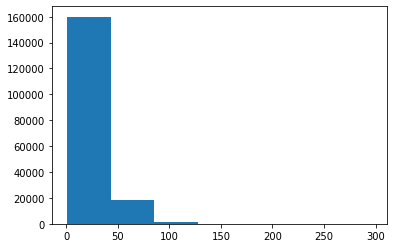

In [19]:
# Plotting what the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=7);

In [20]:
# Checking how long of sentences covers 95% 
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [21]:
# Creating text vectorization layer
from tensorflow.keras import layers
text_vectorizer=layers.TextVectorization(max_tokens=68000,
                                         output_sequence_length=output_seq_len,
                                         name="text_vectorizer")

In [22]:
# Adapting text vectorization to text sentences
text_vectorizer.adapt(train_sentences)

In [23]:
# Checking how many words in training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Last common word in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Last common word in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


#### Creating embedding layer

In [24]:
# Creating token embedding layer
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True,
                             name="token_embedding")

### Starting modelling experiments

In this project, I'll be replicating the model described in the paper: https://arxiv.org/pdf/1612.05251.pdf

* Model_0: Naive Bayes Classifier (Baseline model)
* Model_1: Conv1D Model with token embeddding
* Model_2: Model using pretrained token embedding (universal sentence embedding)
* Model_3: Conv1D model with character level embedding
* Model_4: Model with both token and character embedding 
* Model_5: Model with token,character level and positional level embedding 
* Model _6: Same model as model_5 but with BERT embedding layer

#### Baseline_model: Naive Bayes Classifier

##### Buiding Baseline model and fitting it to training data

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0=Pipeline([
   ("tf-idf", TfidfVectorizer()),
   ("clf", MultinomialNB())
])
# Fit the pipeline to training data
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

##### Evaluating and making predictions with baseline_model

In [26]:
# Evaluating model_0
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [27]:
# Making prediction with model_0
model_0_preds=model_0.predict(val_sentences)
model_0_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
# Creating a function to evaluate model's performance and return a dictionary
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_=precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results={"model_accuracy": model_accuracy,
                 "model_precision": model_precision,
                 "model_recall": model_recall,
                 "model_f1": model_f1}
  return model_results

In [29]:
# Calculating the performance of baseline model
model_0_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_0_preds)
model_0_results

{'model_accuracy': 0.7218323844829869,
 'model_precision': 0.7186466952323352,
 'model_recall': 0.7218323844829869,
 'model_f1': 0.6989250353450294}

#### Model_1:  Conv1D model with token embedding

##### Building and getting a summary of model_1

In [30]:
from tensorflow.keras import layers

# Building Conv1D model
input=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(input)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(filters=64,
                kernel_size=5,
                padding="same",
                activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
output=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(input,output)

# Getting summary of model_1
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVector  (None, 55)               0         
 ization)                                                        
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

##### Creating datasets (make sure that data loads as fast as possible)

In [31]:
# Turning data into TensorSlicesDatasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

# Taking TensorSlicesDatasets and turning them into prefetch batches
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset,val_dataset,test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##### Compiling and fitting model_1

In [32]:
# Compiling model_1
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fitting model_1
history_1=model_1.fit(train_dataset,
                      epochs=5,
                      steps_per_epoch=len(train_dataset),
                      validation_data=val_dataset,
                      validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 57s 8ms/step - loss: 0.6128 - accuracy: 0.7770 - val_loss: 0.5438 - val_accuracy: 0.8009
Epoch 2/5
5627/5627 [==============================] - 44s 8ms/step - loss: 0.4504 - accuracy: 0.8423 - val_loss: 0.5411 - val_accuracy: 0.8055
Epoch 3/5
5627/5627 [==============================] - 44s 8ms/step - loss: 0.3711 - accuracy: 0.8731 - val_loss: 0.5723 - val_accuracy: 0.7992
Epoch 4/5
5627/5627 [==============================] - 45s 8ms/step - loss: 0.3079 - accuracy: 0.8976 - val_loss: 0.6330 - val_accuracy: 0.7872
Epoch 5/5
5627/5627 [==============================] - 44s 8ms/step - loss: 0.2547 - accuracy: 0.9174 - val_loss: 0.7109 - val_accuracy: 0.7846


##### Evaluating and making predictions with model_1

In [33]:
# Evaluating model_1
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7068 - accuracy: 0.7926


[0.7067602276802063, 0.7925989627838135]

In [34]:
# Making prediction with model_1 and converting it into labels
model_1_pred_probs=model_1.predict(val_sentences)
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 2, 1])>

In [35]:
# Calcualting the performance of model_1
model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)

##### Saving model_1

In [36]:
# Creating a function to save model
def save_model(model,save_dir):
  model.save(save_dir)

In [37]:
# Saving model_1
save_model(model=model_1,
           save_dir="/content/drive/MyDrive/skimlit_models/Conv1D_token_embedding_model")

#### Model_2: Model using pretrained token embedding (universal sentence embedding)

##### Building and getting a summary of model_2

In [38]:
import tensorflow_hub as hub

# Downloading pretrained TensorFlow Hub USE
sentence_encoder=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                trainable=False,
                                name="universal_sentence_encoder")

In [39]:
# Building pretrained TensorFLow Hub USE
input=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=sentence_encoder(input)
x=layers.Dense(128,activation="relu")(pretrained_embedding)
output=layers.Dense(num_classes,activation="softmax")(x)
model_2=tf.keras.Model(input,output)

# Getting a summary of model_2
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


##### Compiling and fitting model_2

In [40]:
# Compiling model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fitting model_2
history_2=model_2.fit(train_dataset,
                      epochs=5,
                      steps_per_epoch=len(train_dataset),
                      validation_data=val_dataset,
                      validation_steps=int(0.1*len(val_dataset)))

Epoch 1/5
5627/5627 [==============================] - 63s 11ms/step - loss: 0.7294 - accuracy: 0.7211 - val_loss: 0.6499 - val_accuracy: 0.7566
Epoch 2/5
5627/5627 [==============================] - 61s 11ms/step - loss: 0.6352 - accuracy: 0.7590 - val_loss: 0.6194 - val_accuracy: 0.7670
Epoch 3/5
5627/5627 [==============================] - 60s 11ms/step - loss: 0.6018 - accuracy: 0.7728 - val_loss: 0.6070 - val_accuracy: 0.7703
Epoch 4/5
5627/5627 [==============================] - 59s 10ms/step - loss: 0.5799 - accuracy: 0.7808 - val_loss: 0.6011 - val_accuracy: 0.7716
Epoch 5/5
5627/5627 [==============================] - 58s 10ms/step - loss: 0.5633 - accuracy: 0.7871 - val_loss: 0.5978 - val_accuracy: 0.7743


##### Evaluating and making predictions with model_2


In [41]:
# Evaluating model_2
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.5979 - accuracy: 0.7736


[0.5979001522064209, 0.7735667824745178]

In [42]:
# Making predictions with model_2
model_2_pred_probs=model_2.predict(val_sentences)
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [43]:
# Calculating model_2 performance
model_2_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_2_preds)

##### Saving model_2

In [44]:
# Saving model_2
save_model(model=model_2,
           save_dir="/content/drive/MyDrive/skimlit_models/Universal_sentence_encoder_token_embedding_model")

#### Model_3: Conv1D model with character level embedding

##### Creating character level tokenizer


In [45]:
# Creating a function to split sentences into character
def split_chars(text):
  return " ".join(list(text))

In [46]:
# Splitting sequence-level data splits into character-level data splits
train_char=[split_chars(sentence) for sentence in train_sentences]
val_char=[split_chars(sentence) for sentence in val_sentences]
test_char=[split_chars(sentence) for sentence in test_sentences]

train_char[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [47]:
import numpy as np

# Getting the average character length
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_lens=np.mean(char_lens)
mean_char_lens

149.3662574983337

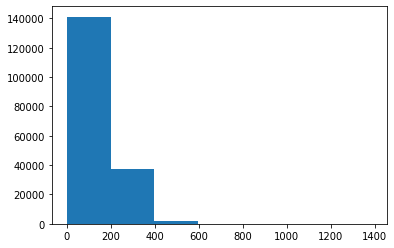

In [48]:
# Checking the distribuation of sequence at character level 
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [49]:
# Finding what character length cover 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [50]:
# Getting all keyboard character
import string 
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
# Creating char-level text vectorizer
num_char_token=len(alphabet)+2
char_vectorizer=layers.TextVectorization(max_tokens=num_char_token,
                                         output_sequence_length=output_seq_char_len,
                                         name="char_vectorizer")

In [52]:
# Adapting character vectorizer to training character
char_vectorizer.adapt(train_char)

In [53]:
# Check character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"Number of different characters in charater vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of different characters in charater vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


##### Creating charater level embedding

In [54]:
# Creating char level embedding
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=128,
                            mask_zero=True,
                            name="char_embedding")

##### Building model_3 and getting a summary

In [55]:
# Building Conv1D model with character embedding
input=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(input)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(filters=64,
                kernel_size=5,
                padding="same",
                activation="relu")(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
output=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(input,output)

# Getting a summary of model_3
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 128)          3584      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

##### Creating character level dataset

In [56]:
# Turning data into TensorSlicesDatasets and turning them into prefetch batches
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_char,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_char,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_char,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset,val_char_dataset,test_char_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##### Compiling and fitting model_3

In [57]:
# Compiling model_3
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fitting model_3
history_3=model_3.fit(train_char_dataset,
                      epochs=5,
                      steps_per_epoch=len(train_char_dataset),
                      validation_data=val_char_dataset,
                      validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.8413 - accuracy: 0.6726 - val_loss: 0.7767 - val_accuracy: 0.6961
Epoch 2/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.7251 - accuracy: 0.7251 - val_loss: 0.7470 - val_accuracy: 0.7168
Epoch 3/5
5627/5627 [==============================] - 39s 7ms/step - loss: 0.6991 - accuracy: 0.7363 - val_loss: 0.7353 - val_accuracy: 0.7251
Epoch 4/5
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6830 - accuracy: 0.7433 - val_loss: 0.7204 - val_accuracy: 0.7261
Epoch 5/5
5627/5627 [==============================] - 29s 5ms/step - loss: 0.6651 - accuracy: 0.7506 - val_loss: 0.7013 - val_accuracy: 0.7387


##### Evalauting and making predictions with model_3

In [58]:
# Evaluating model_3 
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6960 - accuracy: 0.7393


[0.6959543824195862, 0.7393419742584229]

In [59]:
# Making predictions with model_3
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [60]:
# Calculating model_3 performance
model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)
model_3_results

{'model_accuracy': 0.7393419833178869,
 'model_precision': 0.7375604097505617,
 'model_recall': 0.7393419833178869,
 'model_f1': 0.7302030141592115}

##### Saving model_3

In [61]:
# Saving model_3
save_model(model=model_3,
           save_dir="/content/drive/MyDrive/skimlit_models/Conv1D_character_embedding_model")

#### Model_4: Model with both token and character embedding

* Create a token-level embedding model (similar to `model_2`)
* Create a character-level embedding model (similar to `model_3`)
* Combine the two with a cocantenate (`layer.concatenate`)
* Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of https://arxiv.org/pdf/1710.06071.pdf
* Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

##### Building and getting a summary of model_4

In [62]:
# Building token inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=sentence_encoder(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# Building char inputs/model
char_input=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(char_input)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_model=tf.keras.Model(char_input,char_bi_lstm)

# Concatenate token and char inputs
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])

# Creating output layers
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

# Construct model with char and token inputs
model_4=tf.keras.Model([token_model.input,char_model.input],output_layer)

# Getting a summary of model_4
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

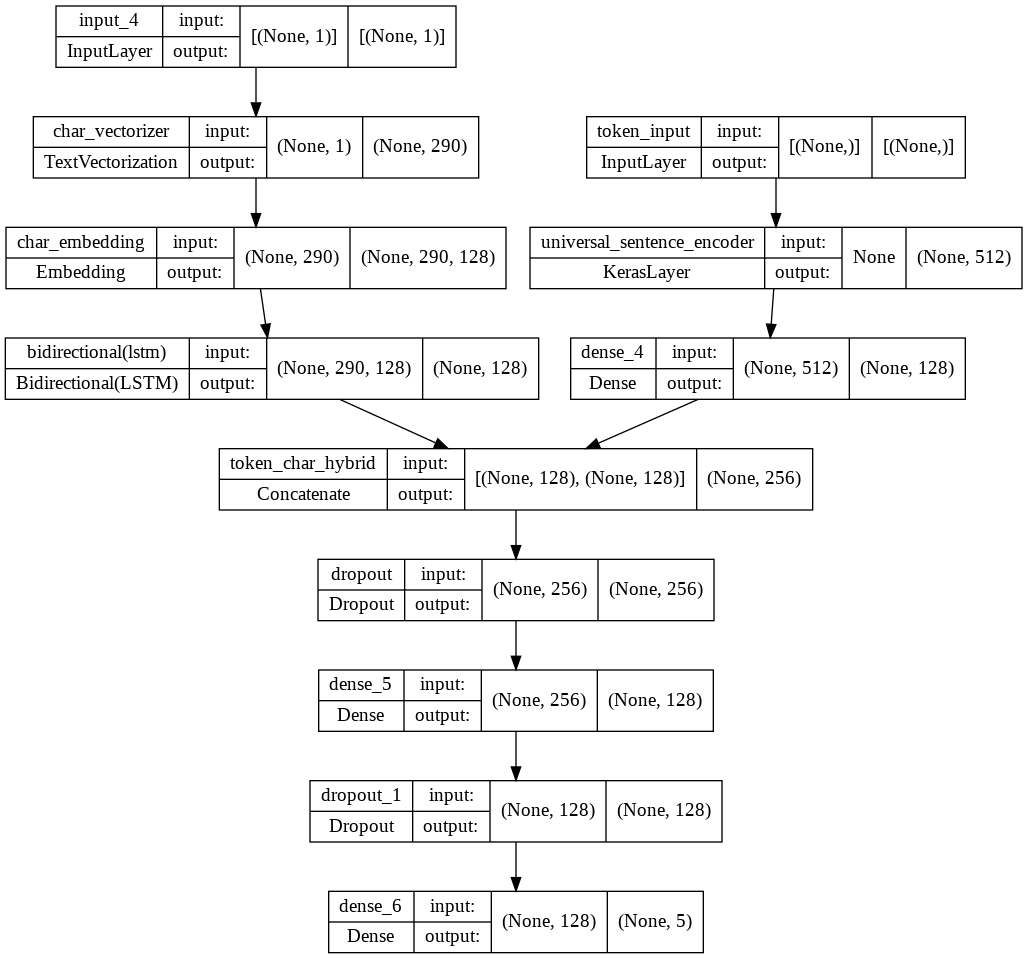

In [63]:
# plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

##### Combining token and character-level data into tf.data.Dataset

In [64]:
# Combine chars and token into a Dataset
train_token_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_char))
train_token_char_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset=tf.data.Dataset.zip((train_token_char_data,train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset=train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
# Combine chars and token into a Dataset
val_token_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_char))
val_token_char_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset=tf.data.Dataset.zip((val_token_char_data,val_token_char_labels))

# Prefetch and batch val data
val_token_char_dataset=val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
# Combine chars and token into a Dataset
test_token_char_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_char))
test_token_char_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset=tf.data.Dataset.zip((train_token_char_data,test_token_char_labels))

# Prefetch and batch test data
test_token_char_dataset=test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

##### Compiling and fitting model_4

In [67]:
# Compiling model_4
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# Fitting model_4
history_4=model_4.fit(train_token_char_dataset,
                      epochs=5,
                      steps_per_epoch=len(train_token_char_dataset),
                      validation_data=val_token_char_dataset,
                      validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/5
5627/5627 [==============================] - 269s 46ms/step - loss: 0.7503 - accuracy: 0.7140 - val_loss: 0.6153 - val_accuracy: 0.7703
Epoch 2/5
5627/5627 [==============================] - 257s 46ms/step - loss: 0.6631 - accuracy: 0.7503 - val_loss: 0.5833 - val_accuracy: 0.7799
Epoch 3/5
5627/5627 [==============================] - 257s 46ms/step - loss: 0.6310 - accuracy: 0.7642 - val_loss: 0.5619 - val_accuracy: 0.7899
Epoch 4/5
5627/5627 [==============================] - 257s 46ms/step - loss: 0.6027 - accuracy: 0.7747 - val_loss: 0.5498 - val_accuracy: 0.7979
Epoch 5/5
5627/5627 [==============================] - 257s 46ms/step - loss: 0.5861 - accuracy: 0.7823 - val_loss: 0.5310 - val_accuracy: 0.8009


##### Evaluating and making predictions with model_4

In [68]:
# Evaluating model_4
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.5319 - accuracy: 0.7991


[0.5319437384605408, 0.7990533709526062]

In [69]:
# Making predictions with model_4
model_4_pred_probs=model_4.predict(val_token_char_dataset)
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [70]:
# Calculating the performance of model_4
model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)
model_4_results

{'model_accuracy': 0.7990533562822719,
 'model_precision': 0.7978969379161253,
 'model_recall': 0.7990533562822719,
 'model_f1': 0.7949536756783602}

##### Saving model_4

In [71]:
# Saving model_4
save_model(model=model_4,
           save_dir="/content/drive/MyDrive/skimlit_models/Universal_sentence_encoder_hybrid_embedding_model")

#### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

* Create a token-level model
* Create a character-level model
* Create a model for the "line_number" feature
* Create a model for the "total_lines" feature
* Combine the outputs 1 & 2 using tf.keras.layers.Concatenate
* Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
* Create an output layer to accept the tribrid embedding nad output label probabilities
* Combine the inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model

##### One-hot encoding the positional embeddings

In [72]:
# Checking how many different line numbers are there
train_data["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

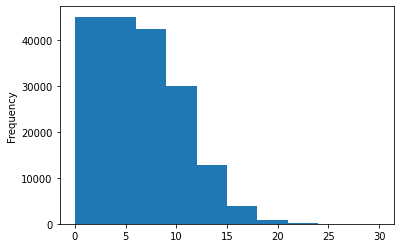

In [73]:
# Check the distribution of "line_number" column
train_data.line_number.plot.hist()

In [74]:
# Using TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot=tf.one_hot(train_data["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_data["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_data["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [75]:
# Checking how many different numbers of lines are there
train_data["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

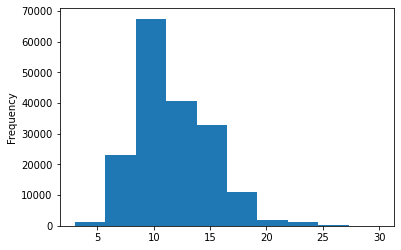

In [76]:
# Check the distributions of total lines
train_data.total_lines.plot.hist()

In [77]:
# Using Tensorflow to create one-hot-encoded-tensors of our "total_lines" feature
train_total_lines_one_hot=tf.one_hot(train_data["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_data["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_data["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

##### Building and getting a summary of model_5



In [78]:
# 1. Token inputs
token_inputs=layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings=sentence_encoder(token_inputs)
token_outputs=layers.Dense(128, activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs=layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs=layers.Input(shape=(15,),dtype=tf.int32, name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,
                                 outputs=x)

# 4. Total lines inputs
total_lines_inputs=layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y=layers.Dense(32,activation="relu")(total_lines_inputs)
total_line_model=tf.keras.Model(inputs=total_lines_inputs,
                                outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings=layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                            char_model.output])
z=layers.Dense(256, activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z=layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                              total_line_model.output,
                                                              z])

# 7. Create output layer
output_layer=layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input, 
                               char_model.input],
                       outputs=output_layer)

# Getting a summary of model_5
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

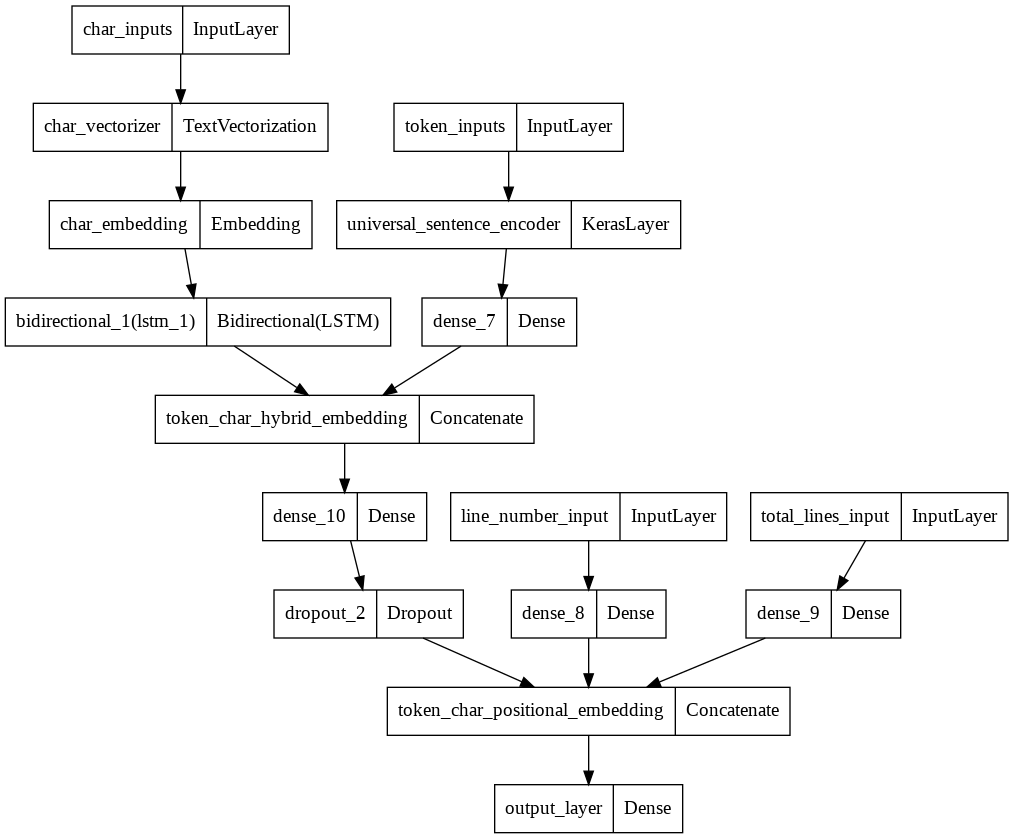

In [79]:
# Plot model_5 to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model_5)

##### Create tribrid embedding datasets using tf.data

In [80]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences, 
                                                                train_char))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_char))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##### Compiling and fitting model_5

In [81]:
# Compiling model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fitting model_5
history_5=model_5.fit(train_pos_char_token_dataset,
                      steps_per_epoch=len(train_pos_char_token_dataset),
                      epochs=5,
                      validation_data=val_pos_char_token_dataset,
                      validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/5
5627/5627 [==============================] - 263s 45ms/step - loss: 0.9511 - accuracy: 0.8257 - val_loss: 0.9134 - val_accuracy: 0.8391
Epoch 2/5
5627/5627 [==============================] - 245s 44ms/step - loss: 0.9068 - accuracy: 0.8561 - val_loss: 0.9022 - val_accuracy: 0.8494
Epoch 3/5
5627/5627 [==============================] - 246s 44ms/step - loss: 0.8940 - accuracy: 0.8653 - val_loss: 0.8998 - val_accuracy: 0.8494
Epoch 4/5
5627/5627 [==============================] - 248s 44ms/step - loss: 0.8851 - accuracy: 0.8719 - val_loss: 0.8968 - val_accuracy: 0.8491
Epoch 5/5
5627/5627 [==============================] - 250s 44ms/step - loss: 0.8783 - accuracy: 0.8769 - val_loss: 0.8976 - val_accuracy: 0.8524


##### Evaluating and making predictions with model_5

In [82]:
# Evaluating model_5
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 22s 24ms/step - loss: 0.8934 - accuracy: 0.8574


[0.8933600783348083, 0.8574407696723938]

In [83]:
# Making predictions with model_5
model_5_pred_probs=model_5.predict(val_pos_char_token_dataset)
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [84]:
# Calculating the performance of model_5
model_5_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_5_preds)
model_5_results

{'model_accuracy': 0.8574407520190652,
 'model_precision': 0.8594345786860588,
 'model_recall': 0.8574407520190652,
 'model_f1': 0.8542602927148621}

##### Saving model_5

In [85]:
# Saving model_5
save_model(model=model_5,
           save_dir="/content/drive/MyDrive/skimlit_models/Universal_sentence_encoder_Tribrid_embedding_model")

### Comparing model Results

In [86]:
# Combining model result into a DataFrame
all_model_results=pd.DataFrame({"Naive_bayes_Classifier":model_0_results,
                                "Conv1D_token_embedding": model_1_results,
                                "Universal_sentence_encoder_token_embedding": model_2_results,
                                "Conv1D_character_embedding":model_3_results,
                                "Universal_sentence_encoder_hybrid_embedding": model_4_results,
                                "Universal_sentence_encoder_tribrid_embedding": model_5_results})

all_model_results=all_model_results.transpose()
all_model_results

,model_accuracy,model_precision,model_recall,model_f1
Naive_bayes_Classifier,0.721832,0.718647,0.721832,0.698925
Conv1D_token_embedding,0.792599,0.789206,0.792599,0.789847
Universal_sentence_encoder_token_embedding,0.773567,0.771744,0.773567,0.769572
Conv1D_character_embedding,0.739342,0.737560,0.739342,0.730203
Universal_sentence_encoder_hybrid_embedding,0.799053,0.797897,0.799053,0.794954
Universal_sentence_encoder_tribrid_embedding,0.857441,0.859435,0.857441,0.854260


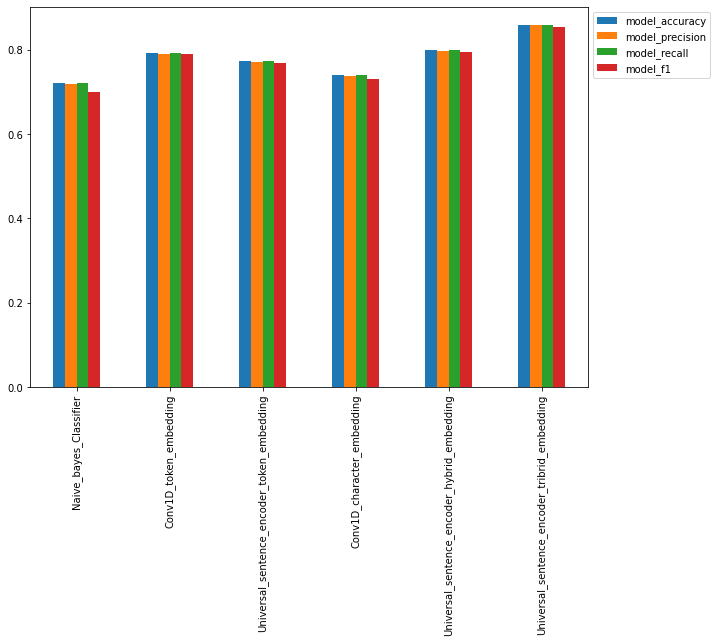

In [87]:
# Plot and compare all model results
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

### Making predictions with the best performing model (Universal_Sentence_encoder_tribrid_model) on the test samples.


#### Loading best performing model

In [88]:
# Loading best performing model from google drive
loaded_tribrid_model=tf.keras.models.load_model("/content/drive/MyDrive/skimlit_models/Universal_sentence_encoder_Tribrid_embedding_model")

#### Creating tribid embedding dataset for the test dataset

In [89]:
# Creating test dataset
test_pos_char_token_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                             test_total_lines_one_hot,
                                                             test_sentences,
                                                             test_char))
test_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset=tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_labels))
test_pos_char_token_dataset=test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#### Making predictions with loaded model and calculating mdel performance

In [90]:
# Making predictions with model_5 on the test samples
test_pred_probs=loaded_tribrid_model.predict(test_pos_char_token_dataset)
test_preds=tf.argmax(test_pred_probs,axis=1)
test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 1])>

In [91]:
# Calculating model's performance on test dataset
test_results=calculate_results(y_true=test_labels_encoded,
                               y_pred=test_preds)
test_results

{'model_accuracy': 0.8534594325535092,
 'model_precision': 0.8540823127674834,
 'model_recall': 0.8534594325535092,
 'model_f1': 0.8501296862807989}

### Finding the most wrong predictions from the samples where the model has predicted the wrong label with the highest prediction probability).

In [92]:
# Creating DataFrame with validation sentences, validation labels and best performing model predictions labels
test_df=pd.DataFrame({"Text": test_sentences,
                      "Target": test_labels_encoded,
                      "Predictions": test_preds})

test_df["Pred_probs"]=tf.reduce_max(test_pred_probs,axis=1)
test_df["Correct"]=test_df["Target"]==test_df["Predictions"]

test_df.head()

,Text,Target,Predictions,Pred_probs,Correct
0,this study analyzed liver function abnormaliti...,0,0,0.367674,True
1,a post hoc analysis was conducted with the use...,4,2,0.552188,False
2,liver function tests ( lfts ) were measured at...,4,2,0.804795,False
3,survival analyses were used to assess the asso...,4,2,0.772356,False
4,the percentage of patients with abnormal lfts ...,4,4,0.764131,True


In [93]:
# Getting the most wrong predictions of the model
most_wrong_predictions=test_df[test_df["Target"]!=test_df["Predictions"]]
most_wrong_predictions[:10]

,Text,Target,Predictions,Pred_probs,Correct
1,a post hoc analysis was conducted with the use...,4,2,0.552188,False
2,liver function tests ( lfts ) were measured at...,4,2,0.804795,False
3,survival analyses were used to assess the asso...,4,2,0.772356,False
20,nor was evar superior regarding cost-utility .,4,1,0.710875,False
23,this study investigated whether oxytocin can a...,2,3,0.447683,False
29,the biological mechanisms by which oxytocin ma...,4,1,0.824240,False
32,previous controlled exposure studies at a conc...,0,2,0.590344,False
44,depressive disorders are one of the leading co...,3,0,0.779785,False
45,numerous studies have demonstrated that pharma...,3,0,0.694182,False
46,psycho-education as an intervention has been s...,3,0,0.613151,False


In [94]:
# Sorting wrong predictions into desending order
wrong_predictions=test_df[test_df["Correct"]==False].sort_values("Pred_probs",ascending=False)
wrong_predictions

,Text,Target,Predictions,Pred_probs,Correct
6365,adverse events up to the third postoperative d...,1,4,0.949082,False
19223,"of the @ dogs receiving placebo , @ ( @ % ) vo...",2,4,0.940350,False
1827,nct@ ( clinicaltrials.gov ) .,1,0,0.932452,False
22736,"the national institute of oncology , budapest ...",3,2,0.930678,False
16347,to evaluate the effects of the lactic acid bac...,0,3,0.930558,False
...,...,...,...,...,...
10088,qualitative interviews suggested that more reg...,4,1,0.262413,False
4884,"this @ - to @-year follow-up ( median , @ year...",0,3,0.257431,False
27234,the purpose of this study was to determine the...,0,3,0.255171,False
15792,"this randomized , three-period - crossover stu...",2,3,0.249157,False


In [95]:
# Investigate top wrong preds
for row in wrong_predictions[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, Predictions, Pred_probs, _ = row
  print(f"Target: {target}, Pred: {Predictions}, Prob: {Pred_probs}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: adverse events up to the third postoperative day occurred similarly in both groups ., Pred: 4, Prob: 0.9490816593170166

Text:
1

-----

Target: of the @ dogs receiving placebo , @ ( @ % ) vomited and @ ( @ % ) developed signs of nausea ; overall , @ of @ ( @ % ) dogs in the placebo treatment group vomited or developed signs of nausea ., Pred: 4, Prob: 0.9403502941131592

Text:
2

-----

Target: nct@ ( clinicaltrials.gov ) ., Pred: 0, Prob: 0.9324519038200378

Text:
1

-----

Target: the national institute of oncology , budapest conducted a single centre randomized clinical study ., Pred: 2, Prob: 0.9306777715682983

Text:
3

-----

Target: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors ., Pred: 3, Prob: 0.9305580854415894

Text:
0

-----

Target: -@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups ., Pred: 4, Prob: 0.9214442372322083

Text:
2

-----

Target: pretest-po